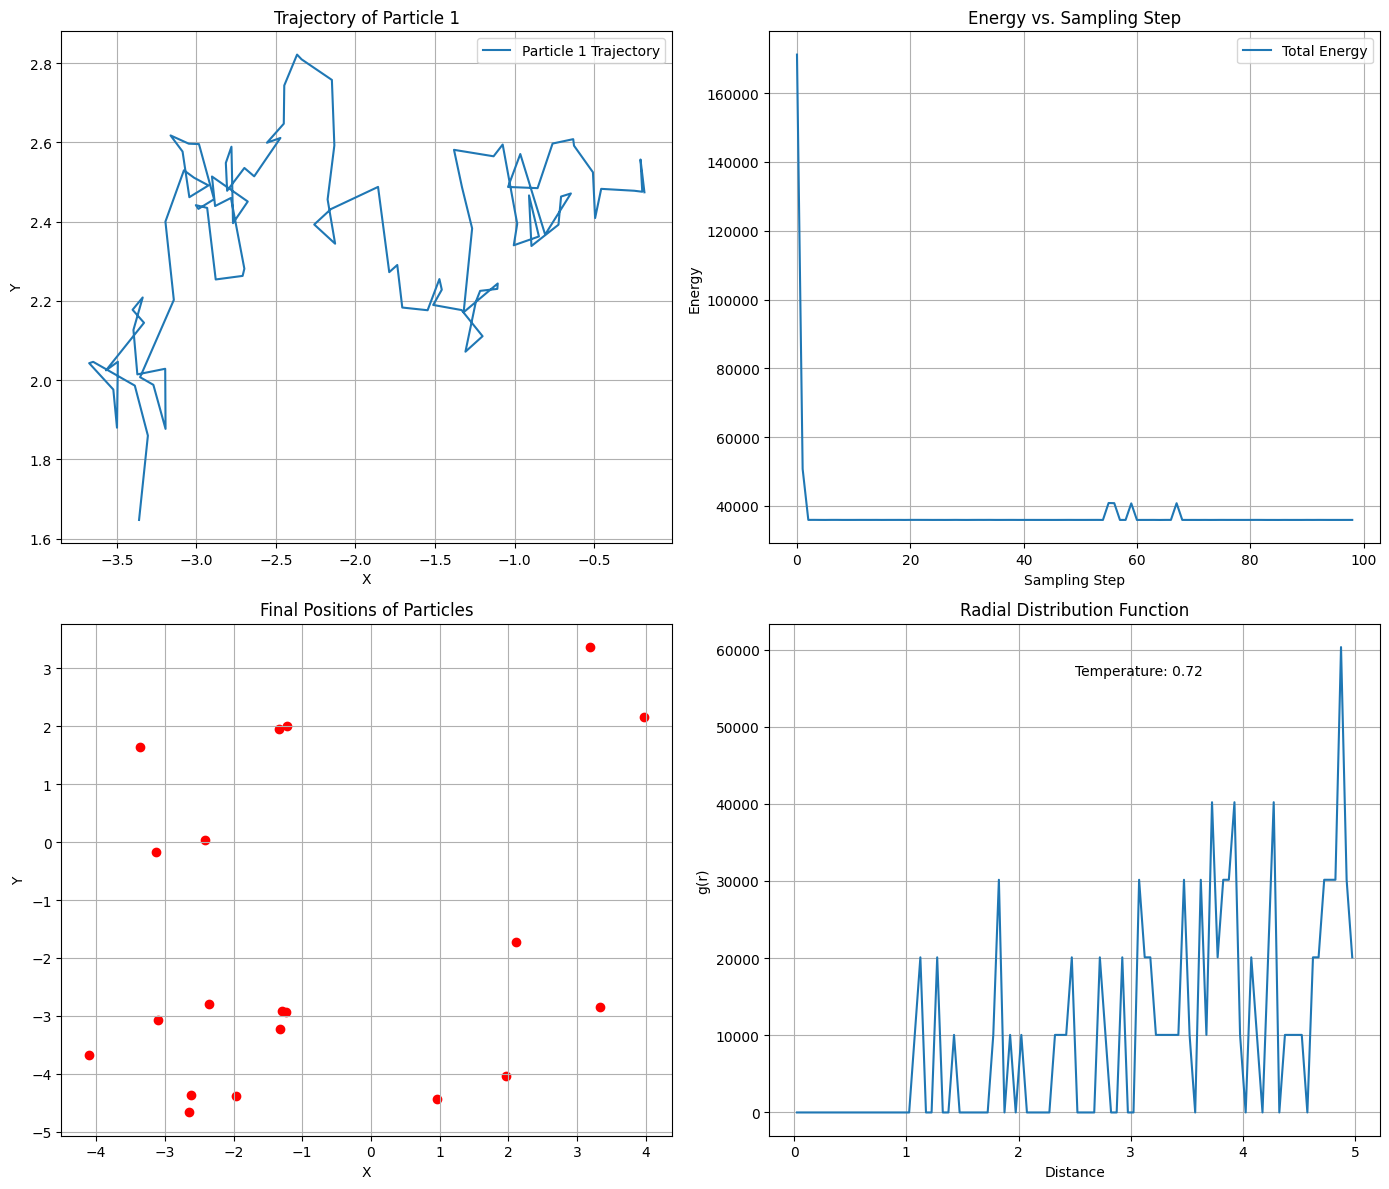

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
N = 20  # Number of particles
L = 10  # Box length
epsilon = 5.0  # Depth of the potential well
sigma = 1.0  # Finite distance at which the inter-particle potential is zero
num_samples = 100  # Number of Gibbs sampling steps
step_size = 0.1  # Step size for sampling
cutoff = 0.5 * L  # Cutoff distance for the potential

def compute_lennard_jones_potential(positions):
    """Compute the total Lennard-Jones potential for a given configuration of particles."""
    U_total = 0.0
    for i in range(N):
        for j in range(i + 1, N):
            r = np.linalg.norm(positions[i] - positions[j])
            U = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)
            if (r > cutoff):
                U = 0.0
            U_total += U
    return U_total

def gibbs_sampling_lennard_jones(num_samples, step_size):
    """Perform Gibbs sampling for particles interacting via the Lennard-Jones potential."""
    positions = L * np.random.rand(N, 3)  # Initial random positions
    U_positions = compute_lennard_jones_potential(positions)

    # Arrays to store data for plotting
    energy_over_time = np.zeros(num_samples)
    positions_over_time = np.zeros((num_samples, N, 3))

    for i in range(num_samples):
        for j in range(N):
            # Sample new position for particle j
            new_position = positions[j] + np.random.normal(0, step_size, 3)

            # Compute potential with the new position
            new_positions = positions.copy()
            new_positions[j] = new_position
            U_new_positions = compute_lennard_jones_potential(new_positions)
            
            # Check if the new position is within the box
            if (new_position[0] > 10):
                new_position[0] = 10
            if (new_position[0] < 0):
                new_position[0] = 0
            if (new_position[1] > 10):
                new_position[1] = 10
            if (new_position[1] < 0):
                new_position[1] = 0

            # Accept or reject the new position based on the potential
            if np.exp(U_positions - U_new_positions) > np.random.rand():
                positions[j] = new_position
                U_positions = U_new_positions
                
        positions_over_time[i] = positions
    
    velocities = (positions_over_time[1:] - positions_over_time[:-1]) / step_size
    kinetic_energy = 0.5 * np.sum(velocities**2, axis=2)
    energy_over_time = compute_lennard_jones_potential(positions_over_time) + np.sum(kinetic_energy, axis=1)

    return positions_over_time, energy_over_time

def radial_distribution_function(positions, box_length, bins=100):
    """Calculate the radial distribution function (RDF)."""
    rdf = np.zeros(bins)
    dr = box_length / (2 * bins)  # Bin width

    for i in range(N):
        for j in range(i + 1, N):
            r_vec = positions[i] - positions[j]
            r_vec -= box_length * np.round(r_vec / box_length)
            r = np.linalg.norm(r_vec)

            bin_index = int(r / dr)
            if bin_index < bins:
                rdf[bin_index] += 2

    normalization = (N * (N - 1) * 4 * np.pi * dr**3) / (3 * box_length**3)
    rdf /= normalization
    r_values = dr * np.arange(bins) + dr / 2
    return r_values, rdf

def temperature(velocities):
    """Calculate the temperature of the system."""
    kinetic_energy = 0.5 * np.sum(velocities**2)
    return (2 / 3) * kinetic_energy / N

# Run the Gibbs sampling simulation
positions_over_time, energy_over_time = gibbs_sampling_lennard_jones(num_samples, step_size)

# Calculate the RDF for the final positions
final_r_values, final_rdf = radial_distribution_function(positions_over_time[-1], L)

# Calculate the temperature for the final positions
final_velocities = (positions_over_time[-1] - positions_over_time[-2]) / step_size
final_temperature = temperature(final_velocities)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Trajectory of the first particle
axs[0, 0].plot(positions_over_time[:, 0, 0], positions_over_time[:, 0, 1], label='Particle 1 Trajectory')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
axs[0, 0].set_title('Trajectory of Particle 1')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Energy plot
axs[0, 1].plot(energy_over_time, label='Total Energy')
axs[0, 1].set_xlabel('Sampling Step')
axs[0, 1].set_ylabel('Energy')
axs[0, 1].set_title('Energy vs. Sampling Step')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Final positions plot
final_positions = positions_over_time[-1]
axs[1, 0].scatter(final_positions[:, 0], final_positions[:, 1], c='red', marker='o')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
axs[1, 0].set_title('Final Positions of Particles')
axs[1, 0].grid(True)

# RDF plot
axs[1, 1].plot(final_r_values, final_rdf)
axs[1, 1].set_xlabel('Distance')
axs[1, 1].set_ylabel('g(r)')
axs[1, 1].set_title('Radial Distribution Function')
axs[1, 1].grid(True)

# Add text annotation for temperature
plt.text(0.5, 0.9, f'Temperature: {final_temperature:.2f}', transform=axs[1, 1].transAxes)

plt.tight_layout()
plt.show()


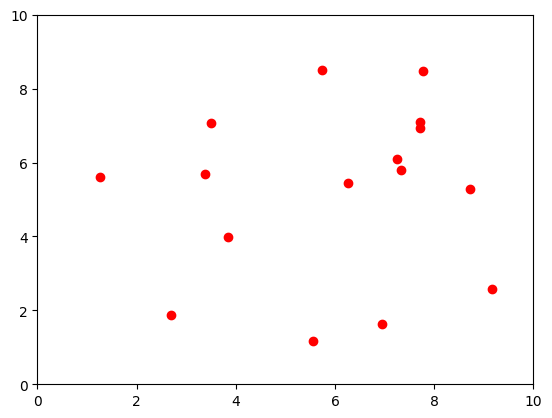

In [107]:
import matplotlib.animation as animation
# Animation
fig, ax = plt.subplots()
particles, = ax.plot(positions_over_time[0, :, 0], positions_over_time[0, :, 1], 'ro')

def init():
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    return particles,

def animate(i):
    particles.set_data(positions_over_time[i, :, 0], positions_over_time[i, :, 1])
    return particles,

ani = animation.FuncAnimation(fig, animate, frames=num_samples, init_func=init, blit=True, interval=50)

plt.show()
